In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Import custom functions from other notebooks
sys.path.append("myfun/")
from ipynb.fs.full.myfun_model_nn import *
from ipynb.fs.full.myfun_density import *

2024-03-03 14:59:06.057247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 14:59:06.057285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 14:59:06.059088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 14:59:06.068462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 14:59:07.072907: W tensorflow/compiler/tf2

# Preliminary

In [2]:
## Params
Nx = 400
Nt = 320
T = 0.5
Ndens = Nx-1 # how many chars, cars trajs to compute

## Exact density
rho_l = 0.4/1.2
rho_r = 0.8/1.2
rho_out = 0
drho = 0.2

In [3]:
# Space - linearly distributed
dx = 1/int(Nx/3)
a = np.linspace(-1,0,int(Nx/3))
b = np.linspace(0+dx/2, 1, Nx-int(Nx/3))
xspan = np.concatenate([a, b])

# Time
tspan = np.linspace(0,T,Nt)

In [4]:
## Exact density flux
f = lambda rho: rho*(1-rho)  
fprime = lambda rho: 1-2*rho
fprime_inv = lambda rho: .5*(1-rho)

# params
toll = 1e-3
xlims = [-1,1]
flux = [f, fprime, fprime_inv]
speed_shock = (f(rho_r) - f(rho_l))/(rho_r - rho_l)

In [5]:
# Load NN10 model
dir_nn = "2023-12-10_11-38-47_df1-2-3-4-5-6-7-8-9-10_500it-PRE-nn10"
target_dir = "./out/"
path = target_dir + dir_nn

namefile_model_nn = "/model_nn10.keras"
model_nn = keras.models.load_model(path + namefile_model_nn)

# Illustration NN10 velocity dependence on consecutive distance

In [6]:
cd = np.linspace(0.01,1,100) # distances
tmp = model_nn(cd, training=False) # velocities predicted
vv = tmp/np.max(tmp) # velocities normalized
dd = 1/cd # densities

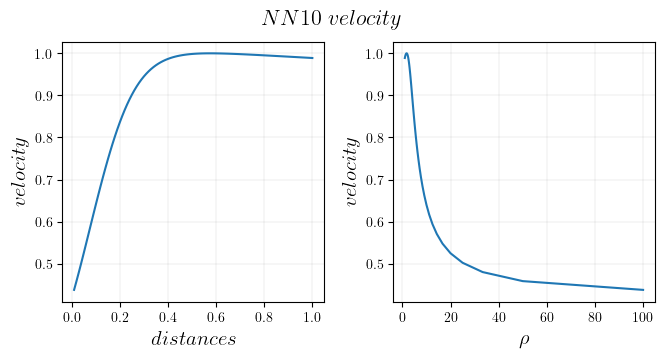

In [7]:
# Initialize the fig
nrow, ncol = 1, 2
width, height = 4.5, 4.5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# AX 0
ax[0].plot(cd, vv)

ax[0].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[0].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[0].set_xlabel(fr"$distances$", fontsize=15)
ax[0].set_ylabel(fr"$velocity$", fontsize=15)

# AX 1
ax[1].plot(dd, vv)

ax[1].grid(color='grey', linestyle='-', linewidth=0.1)
# ax[1].set_title(fr"$NN10\ velocity$", fontsize=18)
ax[1].set_xlabel(fr"$\rho$", fontsize=15)
ax[1].set_ylabel(fr"$velocity$", fontsize=15)

fig.tight_layout()

plt.suptitle(fr"$NN10\ velocity$", fontsize=16,y=1.05);
plt.show()

## NN10 simulation

In [8]:
# Input to compute velocities
x = list(xspan)
x.append(xspan[-1]+dx/2) # artificio
cons_dis = np.diff(x, axis=0) # only two values

# Compute the velocities
y_pred = model_nn(cons_dis, training=False)
tmp = y_pred/np.max(y_pred)
vel_nn = tmp.numpy().flatten().tolist()

In [9]:
## Solve the ODE system in this time interval
sol_ann = odeint(TD_ANN_model, xspan, tspan, args=(vel_nn,), tfirst=True).T
# sol_ann.sort()

# Discretized density
ln = 1/Nx
rho_dis_ann = ln/np.diff(sol_ann, axis=0)

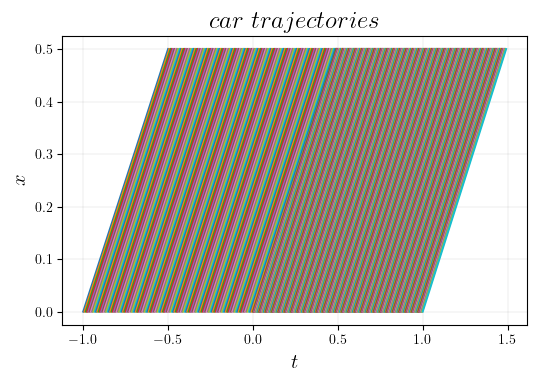

In [10]:
# Initialize the fig
nrow, ncol = 1, 1
width, height = 8, 5 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# AX 0 
for veh in range(0, Nx):
    ax.plot(sol_ann[veh], tspan)

ax.grid(color='grey', linestyle='-', linewidth=0.1)
ax.set_title(fr"$car\ trajectories$", fontsize=18)
ax.set_xlabel(fr"$t$", fontsize=15)
ax.set_ylabel(fr"$x$", fontsize=15)

plt.show()

# Plot discretized density

In [11]:
# Plot params
exact_flag = True
fix_flag = True

idx = 0, int(len(tspan)*.5), -1

Fixing values larger than 0.6675094339622829. Erased 0 values.
Fixing values larger than 0.6675094339622829. Erased 3 values.
Fixing values larger than 0.6675094339622829. Erased 3 values.


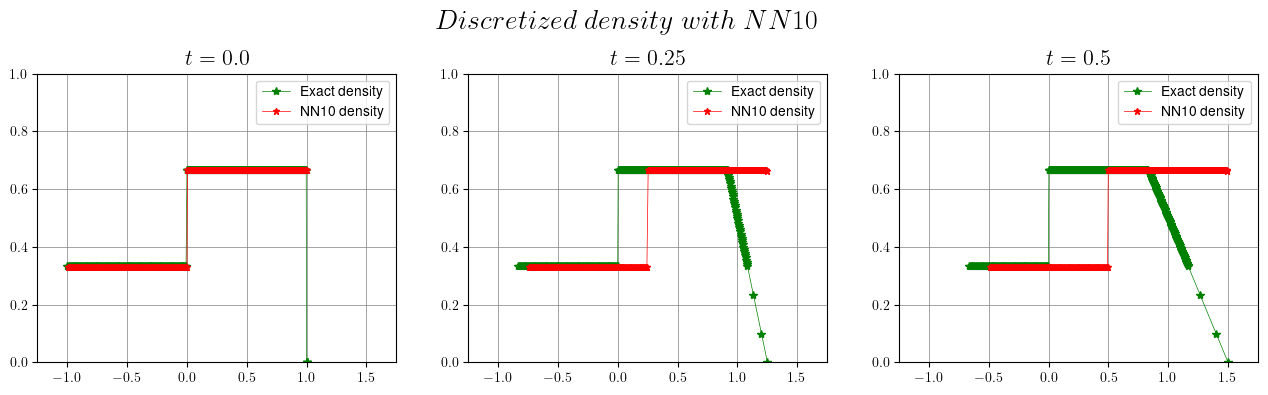

In [12]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

fig.suptitle(fr"$Discretized\ density\ with\ NN10$", fontsize=20, y = 1.05); # Figure titles

for ax, i in zip(axes, idx):
    
    t = tspan[i]

    # exact density
    if exact_flag:
        idx_t, (cp_t, d_t), _, _ = rho_2s(xlims, Ndens, tspan, rho_l, rho_r, rho_out, flux, np.round(t,8), drho)
        ax.plot(cp_t, d_t, c='g', ls = '-', lw = .5, marker='*', label="Exact density")
    
    x = sol_ann[:,i][1:]
    rho = rho_dis_ann[:,i]
    
    # Cutting off values over 1
    if fix_flag:
        x_fixed, rho_fixed = list(x.copy()), list(rho.copy())
        j, rhomax = 0, rho[-20]
        
        while j<len(rho_fixed):
            
            if rhomax-rho_fixed[j] < 0:
                x_fixed.pop(j), rho_fixed.pop(j)
                j = j-1
            
            if rho_fixed[j] < 0:
                x_fixed.pop(j), rho_fixed.pop(j)
                j = j-1
                
            j+=1
            
        print(fr"Fixing values larger than {rhomax}. Erased {len(rho)-len(rho_fixed)} values.")
        x, rho = x_fixed, rho_fixed
        
    ax.plot(x,rho,c='r', ls='-', lw = 0.5, ms=5, marker='*', label="NN10 density")
#     ax.plot(x,x*0,c='blue', ls='', ms=5, marker='o', label="Particles")

    ax.set_xlim([-1.25,1.75])
    ax.set_ylim([0, 1])
    ax.set_title(fr"$t={t.round(2)}$",fontsize=16)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()

plt.show()